In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Functions_GBM as GBM
import Functions_Variance as f_var
import Estimators_Functions as e_fun
from IPython.display import display

# High Frequency Data Simulation & Estimators Analysis

In this notebook, we simulate high-frequency financial time series using a **Geometric Brownian Motion (GBM)**. 
We then validate the statistical properties of the simulation (Normality of returns, Martingale property) and analyze the performance of the **Two-Scales Realized Volatility (TSRV)** estimator in the presence of microstructure noise.

### Theoretical Framework
The asset price $S_t$ follows the stochastic differential equation:
$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:
* $\mu$ is the drift.
* $\sigma$ is the volatility.
* $W_t$ is a Wiener process.

## 1. Simulation of Price Paths (GBM)
We simulate $N$ paths using the analytical solution of the GBM:
$$S_t = S_0 \exp\left( (\mu - \frac{1}{2}\sigma^2)t + \sigma W_t \right)$$

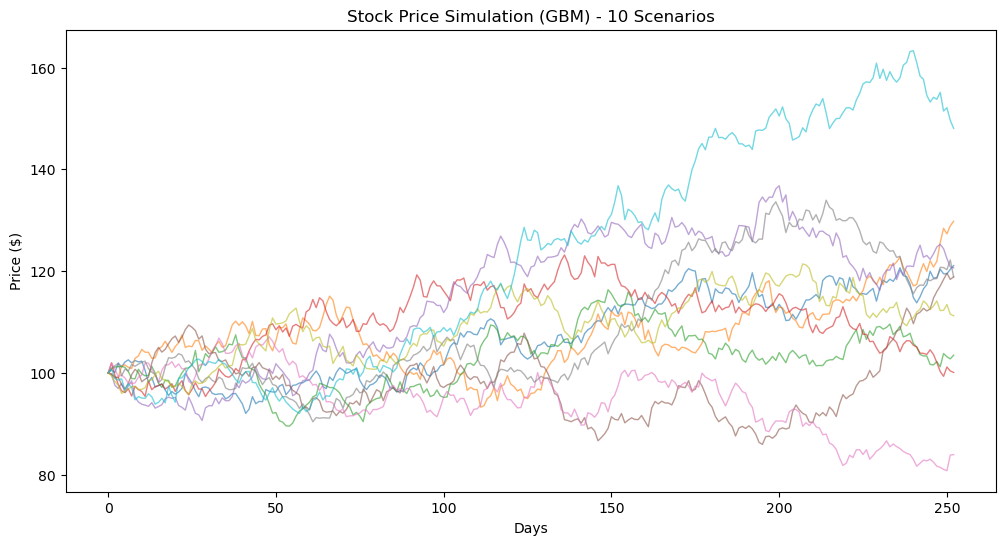

In [18]:
df_prices = GBM.sim_gbm_paths(S0=100, mu=0.05, sigma=0.2, T=252, dt=1/252, n_paths=10)
GBM.plot_gbm_paths(df_prices)

## 2. Statistical Validation
We verify that the Log-Returns $r_t = \ln(S_t / S_{t-1})$ follow a Normal Distribution:
$$r_t \sim \mathcal{N}\left( (\mu - \frac{1}{2}\sigma^2)\Delta t, \sigma^2 \Delta t \right)$$

We compute the first four moments (Mean, Variance, Skewness, Kurtosis) and perform the **Jarque-Bera test** to validate the normality assumption.

In [19]:
GBM.statistics_gbm(df_prices)

       EMPIRICAL GBM STATISTICS (Log-Returns)
Paths Drifts Mean:      0.000534
Paths Variance Mean:  0.000154
Paths Skewness Mean:   0.0333
Paths Kurtosis Mean:   0.0563
Normal Returns Assumption Validated through Jarque-Bera Test.


,Mean,Variance,Skewness,Kurtosis
0,0.000760,0.000131,-0.132200,0.243107
1,0.001035,0.000181,-0.214886,-0.007909
2,0.000136,0.000151,-0.033259,0.116976
3,0.000004,0.000153,0.151087,-0.366591
4,0.000745,0.000162,-0.007593,-0.011932
5,0.000686,0.000167,0.222633,0.026858
6,-0.000694,0.000164,0.115823,-0.067584
7,0.000685,0.000138,0.187066,0.004801
8,0.000422,0.000137,-0.112848,0.243573
9,0.001557,0.000155,0.156879,0.381925


## 3. Realized Volatility Verification

To further validate the simulation, we compute the **Realized Volatility (RV)** for each of the $N$ generated paths.

$$RV = \sum_{t=1}^{N} r_t^2$$

We verify that the mean of the empirical Realized Volatilities across all paths converges to the theoretical expected variance (Integrated Volatility) used in the simulation parameters ($\sigma^2 T$).

In [20]:
rv = f_var.calculate_rv_per_path(df_prices)
display(pd.DataFrame(rv, columns=["Realized Volatility"]))
print("=" * 80)
rv_mean = f_var.calculate_mean_rv(rv)

The Realized Volatility for each simulated path is:


,Realized Volatility
0,0.032931
1,0.045669
2,0.037958
3,0.038313
4,0.040839
5,0.041959
6,0.041398
7,0.034708
8,0.034337
9,0.039618


The Mean Realized Volatility between all simulated paths is: 0.03877296522043291


## 4. Martingale Property Test
The discounted price process $\tilde{S}_t = e^{-\mu t} S_t$ must be a martingale under the measure $\mathbb{P}$:
$$\mathbb{E}[\tilde{S}_t | \mathcal{F}_0] = S_0$$

We verify this property in two ways:
1.  **Visual Inspection:** Checking if the mean of the simulated discounted paths converges to the initial price $S_0$.
2.  **Statistical Test:** Performing a T-test on the final values to ensure there is no significant bias.

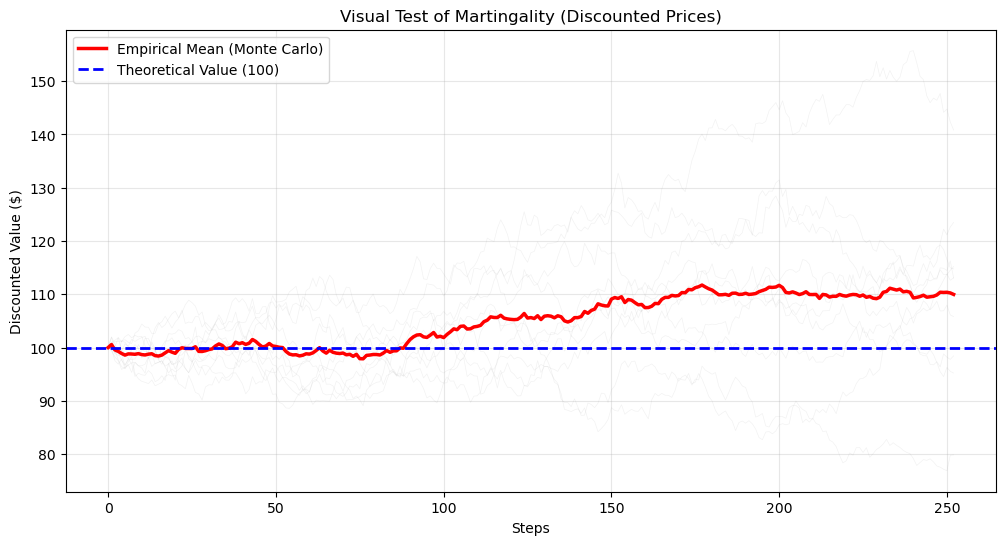

In [21]:
mart_paths, mart_mean = GBM.martingale(df_prices, dt=1/252, mu=0.05)
GBM.plot_martingale_test(mart_paths, mart_mean, S0=100)

In [22]:
GBM.test_martingale_statistics(mart_paths, S0=100)

       MARTINGALITY T-TESTS ON DISCOUNTED PRICES       
Final Empirical Mean: 109.9716 (Target: 100)
T-Statistic: 1.8998
P-Value:     0.0899
>> Do not Reject H0. IT IS A MARTINGALE.


## 5. Two-Scales Realized Volatility (TSRV)
We introduce **microstructure noise** $\epsilon_t \sim \mathcal{N}(0, \eta^2)$ to the efficient price $X_t$ (log-price) to simulate real-world high-frequency data:
$$Y_t = X_t + \epsilon_t$$

We compare two estimators:
1.  **Realized Volatility (RV):** Which is biased and inconsistent under noise.
2.  **TSRV:** Which corrects for the bias using subsampling (Fast and Slow time scales).

### 5.1 Optimization of Sparse Parameter ($K$)
The TSRV estimator depends on a sparsity parameter $K$ (or $n_{sparse}$). We perform a **Grid Search** to find the optimal $K$ that minimizes the Mean Squared Error (MSE) against the true Integrated Volatility.

In [33]:
noisy_prices = e_fun.add_micro_noise(df_prices, n_paths=10)
# qui sopra checkare che non venga aggiunto il noise alla prima riga
rv_naive = f_var.calculate_mean_rv2(f_var.calculate_rv_per_path2(df_prices))
rv_sparse = f_var.calculate_mean_rv2(f_var.calculate_rv_per_path2(noisy_prices[::4])) # ogni 4 osservazioni
tsrv = np.array(e_fun.tsrv_estimator(noisy_prices, K=4))
print("=" * 103)
print(f"The Naive Estimator for Integrated Volatility is: {rv_naive}")
print("=" * 103)
print(f"The Sparse Estimator for Integrated Volatility is: {rv_sparse}. (every 4 obs.)")
print("=" * 103)
print(f"The Zhang Estimator for Integrated Volatility (with K=4, standard literature) is: {tsrv}")
print("=" * 103)
err_tsrv = e_fun.calculate_error(tsrv, rv_mean)
print(f"TSRV Error: {err_tsrv*100:.2f}%")


The Naive Estimator for Integrated Volatility is: 0.03877296522043291
The Sparse Estimator for Integrated Volatility is: 0.04161106024755518. (every 4 obs.)
The Zhang Estimator for Integrated Volatility (with K=4, standard literature) is: 0.03900606537092868
TSRV Error: 0.60%


In [35]:
df_results = e_fun.generate_tsrv_table(
    prices=noisy_prices, 
    true_iv=rv_naive, 
    k_range=range(2 ,1000, 1), 
    k_chosen=4
)
display(df_results)

,Optimal K,TSRV (Optimal K),TSRV (K=4)
0,32,0.038827,0.039006
1,32,0.038827,0.039006
2,32,0.038827,0.039006
3,32,0.038827,0.039006
4,32,0.038827,0.039006
5,32,0.038827,0.039006
6,32,0.038827,0.039006
7,32,0.038827,0.039006
8,32,0.038827,0.039006
9,32,0.038827,0.039006


### 5.2 Consistency Check: Volatility Signature Plot
We analyze the behavior of the estimators as the sampling frequency $N$ increases (from low frequency to ultra-high frequency).

* **RV Consistency:** We expect RV to diverge as $N \to \infty$ due to noise accumulation.
* **TSRV Consistency:** We expect TSRV to remain stable and converge to the True Integrated Volatility.

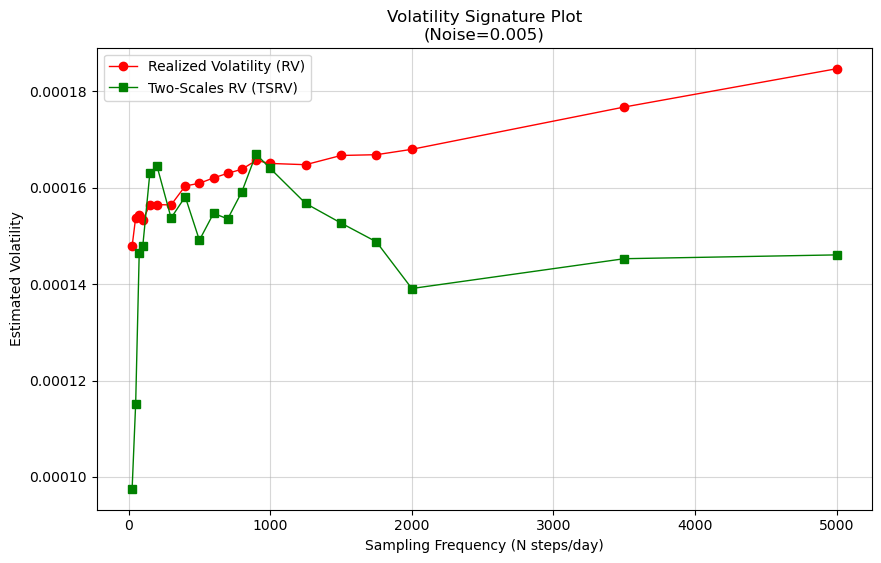

In [36]:
e_fun.plot_consistency_check(0.05, 0.2, 100, 0.005, n_paths=10)

## 6. EXAMPLE: High-Frequency Simulation Setup

To properly evaluate the **Two-Scales Realized Volatility (TSRV)** estimator and replicate the findings regarding microstructure noise, we must simulate a price process at a very fine granularity.

We define the simulation parameters to generate **tick-by-tick data** (1 second resolution) for a standard trading day (6.5 hours).

**Simulation Parameters:**
* **Trading Duration ($s$):** 23,400 seconds (corresponding to 6.5 hours of trading).
* **Time Horizon:** $N_{DAYS} = 1$.
* **High-Frequency Time Step ($dt_{HF}$):** The annualized duration of a single second:
$$dt_{HF} = \frac{1}{252 \times s}$$

### Simulation Parameters configuration

The parameters we decided to establish for this high-frequency example are:

* **Trading Seconds per Day ($s$):** $23,400$ (corresponding to 6.5 trading hours).
* **Time Horizon ($N_{DAYS}$):** $1$ Day.
* **Total Time Steps ($T_{steps}$):** $23,400$ ticks (1-second resolution).
* **Drift ($\mu$):** $0.05$ ($5\%$ annualized return).
* **Volatility ($\sigma$):** $0.20$ ($20\%$ annualized volatility).
* **Initial Price ($S_0$):** $100$.
* **Number of Paths ($N_{PATHS}$):** $10$ scenarios.
* **Time Step ($dt_{HF}$):** $\frac{1}{252 \times 23400} \approx 1.69 \times 10^{-7}$.

In [37]:
s = 23400 # 6.5 H of trading
N_DAYS = 1
T_steps = N_DAYS * s 
dt_hf = 1 / (252 * s) 
MU = 0.05
SIGMA = 0.2
S0 = 100
N_PATHS = 10

### 6.1 Simulation of Efficient Prices (GBM)

We simulate the "efficient" price process $X_t$ (log-price) which follows a Geometric Brownian Motion without any market microstructure noise. This represents the latent, true value of the asset.

$$X_t = X_{t-1} + \mu dt + \sigma \sqrt{dt} \epsilon_t$$

The corresponding price $S_t = e^{X_t}$ is then plotted for all $N_{PATHS}$ scenarios to visualize the underlying asset dynamics before noise contamination.

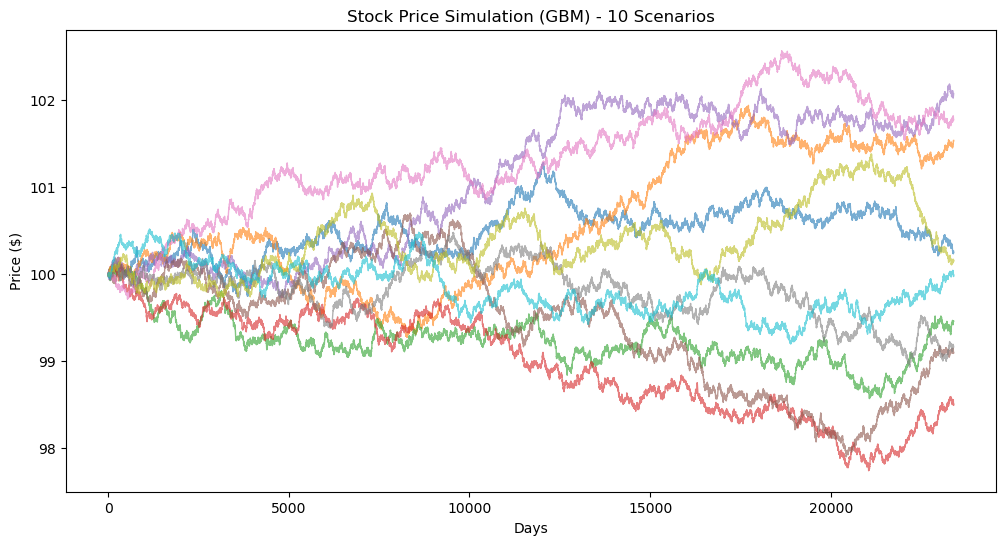

In [38]:
df_prices_hf = GBM.sim_gbm_paths(
    n_paths=10, # Meno path per velocità se T è alto
    T=T_steps, 
    mu=0.05, 
    sigma=0.2, 
    S0=100, 
    dt=dt_hf
)
GBM.plot_gbm_paths(df_prices_hf)

### 6.2 Microstructure Noise Contamination

Real high-frequency prices are never observed directly; they are contaminated by **microstructure noise** (due to bid-ask bounce, discrete trading, etc.).

We model the *observed price* $Y_t$ as the true efficient price $X_t$ plus an i.i.d. noise component $\epsilon_t$:

$$Y_t = X_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma_{\eta}^2)$$

We apply this additive noise to our simulated price paths to generate realistic high-frequency data.

In [39]:
df_noisy_hf = e_fun.add_micro_noise(df_prices_hf, n_paths=10)

### 6.3 Statistical Validation of Efficient Returns

Before analyzing the noise, we must verify that our underlying simulation of the efficient price ($X_t$) correctly follows a **Geometric Brownian Motion**.

We compute the empirical statistics of the high-frequency **Log-Returns** $r_t = \ln(S_t / S_{t-1})$. For a GBM, we expect:
* **Skewness** $\approx 0$ (Symmetric distribution)
* **Excess Kurtosis** $\approx 0$ (Normal tails, no fat tails)

In [40]:
df_stats = GBM.statistics_gbm(df_prices_hf)
display(df_stats)

       EMPIRICAL GBM STATISTICS (Log-Returns)
Paths Drifts Mean:      0.000000
Paths Variance Mean:  0.000000
Paths Skewness Mean:   -0.0060
Paths Kurtosis Mean:   -0.0076
Normal Returns Assumption Validated through Jarque-Bera Test.


,Mean,Variance,Skewness,Kurtosis
0,1.107383e-07,6.871480e-09,-0.009007,0.010626
1,6.508383e-07,6.761944e-09,-0.007149,-0.025602
2,-2.323143e-07,6.796215e-09,0.000259,-0.003678
3,-6.437575e-07,6.739719e-09,-0.029804,0.018932
4,8.769814e-07,6.781389e-09,-0.005540,0.053657
5,-3.869247e-07,6.867460e-09,0.006102,-0.007819
6,7.506832e-07,6.774167e-09,-0.014419,-0.049720
7,-3.599033e-07,6.733166e-09,-0.019245,-0.033914
8,6.215260e-08,6.768428e-09,0.008153,-0.002854
9,-4.989134e-09,6.679738e-09,0.010214,-0.035899


### 6.4 Martingale Property Verification

To validate the consistency of our simulation scheme, we verify the **Martingale Property** of the discounted price process. In a risk-neutral world (or under the measure generated by our drift $\mu$), the discounted price process $\tilde{S}_t = e^{-\mu t} S_t$ should have no drift.

$$\mathbb{E}[\tilde{S}_t | \mathcal{F}_0] = S_0$$

We perform two tests:
1.  **Visual Test:** Plotting the mean of the discounted paths over time. It should coincide with the constant line $S_0$.
2.  **Statistical Test:** A T-test on the final values $\tilde{S}_T$ to formally accept or reject the null hypothesis $H_0: \mathbb{E}[\tilde{S}_T] = S_0$.

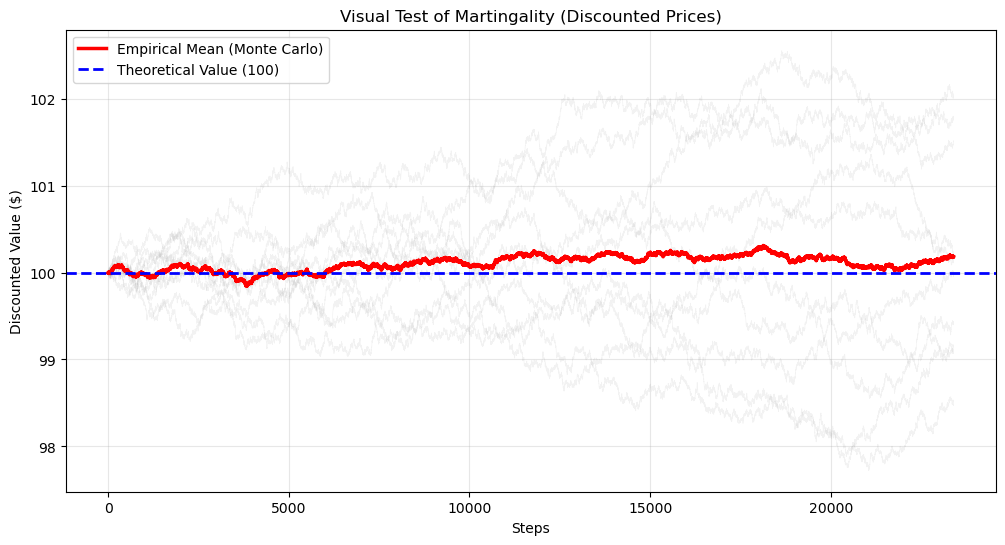

       MARTINGALITY T-TESTS ON DISCOUNTED PRICES       
Final Empirical Mean: 100.1797 (Target: 100)
T-Statistic: 0.4637
P-Value:     0.6539
>> Do not Reject H0. IT IS A MARTINGALE.


In [41]:
mart_paths, mart_mean = GBM.martingale(df_prices_hf, dt_hf, MU)
GBM.plot_martingale_test(mart_paths, mart_mean, S0)
GBM.test_martingale_statistics(mart_paths, S0)

### 6.5 TSRV Parameter Optimization (Grid Search)

The performance of the **Two-Scales Realized Volatility (TSRV)** estimator critically depends on the choice of the sparse sampling parameter $K$ (or $n_{sparse}$).

To find the optimal $K$, we perform a **Grid Search** minimizing the Mean Squared Error (MSE) between the estimator applied to noisy data and the **True Integrated Volatility** derived from the clean price process.

$$K_{opt} = \underset{K}{\arg\min} \mathbb{E}\left[ (\text{TSRV}(Y_t, K) - IV_{true})^2 \right]$$

* **Input:** Noisy Prices $Y_t$.
* **Target:** True Volatility calculated on Efficient Prices $X_t$.

In [44]:
rv_naive_hf = f_var.calculate_rv_per_path(df_prices_hf) # Vettore RV Naive
df_results_hf = e_fun.generate_tsrv_table(
    prices=df_noisy_hf, 
    true_iv=rv_naive_hf,
    k_range=range(2, 500, 1), 
    k_chosen=60
)
display(df_results_hf)

The Realized Volatility for each simulated path is:


,Optimal K,TSRV (Optimal K),TSRV (K=60)
0,6,0.000159,0.000155
1,6,0.000159,0.000155
2,6,0.000159,0.000155
3,6,0.000159,0.000155
4,6,0.000159,0.000155
5,6,0.000159,0.000155
6,6,0.000159,0.000155
7,6,0.000159,0.000155
8,6,0.000159,0.000155
9,6,0.000159,0.000155


### 6.6 Consistency Check: Volatility Signature Plot

Finally, we perform the **Volatility Signature Plot** analysis to verify the consistency of the estimators across different sampling frequencies.

We fix the microstructure noise standard deviation to $\sigma_{\eta} = 0.005$ and execute the simulation.

We expect to observe:
* **Realized Volatility (RV):** Diverging (increasing) as sampling frequency increases, due to the accumulation of noise variance.
* **TSRV:** Remaining stable and close to the **True Integrated Volatility**, demonstrating its robustness against microstructure noise.

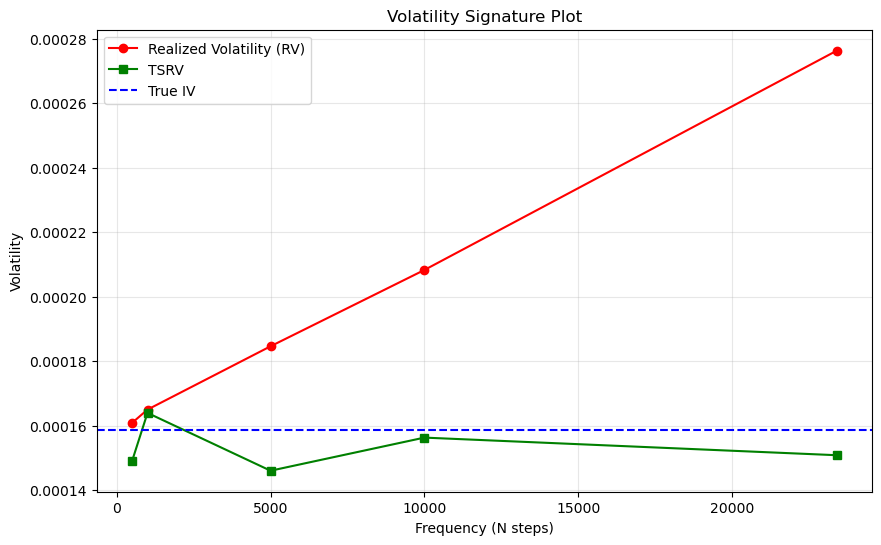

In [45]:
noise_std = 0.005 
e_fun.run_signature_plot(MU, SIGMA, S0, noise_std, N_PATHS)